# Packages

In [298]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast
import math

import pandas as pd
import geopandas as gpd
import numpy as np

# Loading data

In [299]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [300]:
football = pd.read_pickle(RAW_DIR / "football_new.pickle")

# Exporatory Data Analysis

In [301]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_key_pass_id,', 'shot_one_on_one'],
      dtype='object')

In [302]:
football["shot_type"].value_counts()

shot_type
Open Play    43096
Free Kick     2124
Name: count, dtype: int64

In [303]:
football.groupby(["shot_type"])["shot_outcome"].count()

shot_type
Free Kick     2124
Open Play    43096
Name: shot_outcome, dtype: int64

Are we going to look at all the periods? Overtime and also penalty kick?

In [304]:
football["period"].value_counts().sort_index()

period
1    20603
2    24617
Name: count, dtype: int64

I am gonna transform shot outcome column into a 0 and 1 column

In [305]:
football["shot_outcome"].unique().tolist()

['Off T',
 'Goal',
 'Blocked',
 'Saved',
 'Wayward',
 'Post',
 'Saved Off Target',
 'Saved to Post']

I will transform timestamp into a minute ceil column (e.g., 4:32 -> 5th minute)

In [306]:
football["timestamp"].unique()

array(['00:04:21.052', '00:06:27.395', '00:08:16.762', ...,
       '00:45:24.473', '00:45:25.517', '00:47:47.998'],
      shape=(44856,), dtype=object)

I will transform location to a x and y column by making it a list first

In [307]:
football["location"].head()

0    [108.1, 31.2]
1    [110.9, 42.6]
2    [117.9, 29.1]
3    [101.8, 27.6]
4    [109.3, 26.5]
Name: location, dtype: object

<Axes: xlabel='shot_body_part'>

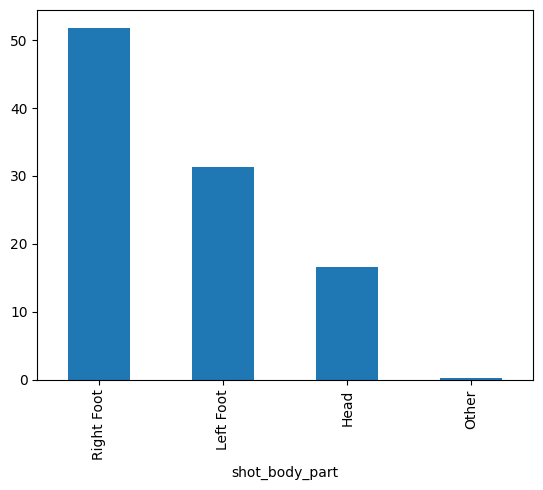

In [308]:
(football["shot_body_part"].value_counts(normalize=True) * 100).plot(kind='bar')

There is no freeze frame data for penalty kicks which makes sense

In [309]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

Series([], Name: count, dtype: int64)

In [310]:
football["shot_outcome"].value_counts()

shot_outcome
Off T               15071
Blocked             11292
Saved               10648
Goal                 4335
Wayward              2702
Post                  860
Saved Off Target      161
Saved to Post         151
Name: count, dtype: int64

# Processing Data

Defining functions to process data

In [311]:
def process_shot_outcome(df):
    outcome_mapping = {
        'Off T': 0,
        'Goal': 1,
        'Blocked': 0,
        'Saved': 0,
        'Wayward': 0,
        'Post': 0,
        'Saved Off Target': 0,
        'Saved to Post': 0
    }

    df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
    return df

def process_shot_body_part(df, add_combine_feet=True):
    dummies = pd.get_dummies(df['shot_body_part'], prefix='body_part', drop_first=False, dtype=int)
    dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")

    if add_combine_feet:
        dummies['body_part_foot'] = dummies.get('body_part_left_foot', 0) + dummies.get('body_part_right_foot', 0)
        dummies.drop(columns=['body_part_left_foot', 'body_part_right_foot'], inplace=True)

    df = pd.concat([df, dummies], axis=1)
    return df

def process_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
    df['time_only'] = df['timestamp'].dt.time
    df['minute'] = df['timestamp'].dt.minute # maybe remove?
    df['second'] = df['timestamp'].dt.second # maybe remove?
    df['minute_ceil'] = df['timestamp'].dt.ceil('min').dt.minute
    return df

def process_location(df, type, col):
    df[[f"{type}_x", f"{type}_y"]] = pd.DataFrame(df[col].tolist(), index=df.index)
    return df

def distance_from_goal(df):
    df['distance_from_goal_center'] = np.sqrt((120 - df['player_x'])**2 + (40 - df['player_y'])**2) # need to double check
    df['distance_from_goal_left_post'] = np.sqrt((120 - df['player_x'])**2 + (36 - df['player_y'])**2)
    df['distance_from_goal_right_post'] = np.sqrt((120 - df['player_x'])**2 + (44 - df['player_y'])**2)
    return df

def goalkeeper_distance_from_goal(df):
    df['gk_distance_from_goal_center'] = np.sqrt((120 - df['goalkeeper_x'])**2 + (40 - df['goalkeeper_y'])**2) # need to double check
    df['gk_distance_from_goal_left_post'] = np.sqrt((120 - df['goalkeeper_x'])**2 + (36 - df['goalkeeper_y'])**2)
    df['gk_distance_from_goal_right_post'] = np.sqrt((120 - df['goalkeeper_x'])**2 + (44 - df['goalkeeper_y'])**2)
    return df

def process_one_hot_encoding(df, cols_to_process):
    # one hot encoding
    for col in cols_to_process:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False, dtype=int)
        dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")
        df = pd.concat([df, dummies], axis=1)
    return df

def encode_true_false(df, cols_to_process):
    # Convert True into 1 and NaN into 0
    for col in cols_to_process:
        df[col] = df[col].fillna(False).astype(int)
    return df


def shot_angle(x, y, 
               post1=(120, 36),   # top post
               post2=(120, 44)):  # bottom post
    """
    Returns shot angle in radians using absolute difference of atan2 angles.
    x, y: shooter coordinates.
    post1, post2: (x,y) of both posts.
    """
    a1 = math.atan2(post1[1] - y, post1[0] - x)
    a2 = math.atan2(post2[1] - y, post2[0] - x)
    return abs(a2 - a1)


def get_opposition_goalkeeper_location(freeze_frame):
    """
    Returns the location of the opposition goalkeeper
    (position='Goalkeeper' and teammate=False).
    """

    for player in freeze_frame:
        if (
            player.get("position", {}).get("name") == "Goalkeeper"
            and player.get("teammate") is False
        ):
            location = player.get("location")
            return location
        
    return None

def distance_player_gk(df):
    df["distance_player_gk"] = np.sqrt((df["player_x"] - df['goalkeeper_x'])**2 + (df["player_y"] - df['goalkeeper_y'])**2)
    return df

Removing rows (corner and penalty shots) and making sure columns are interpreted correctly (e.g., list instead of string for location)

In [312]:
# keep only open play or free kick
football = football[(football["shot_type"] == "Open Play") | (football["shot_type"] == "Free Kick")]
if type(football["location"][0]) != list:
    football["location"] = football['location'].apply(ast.literal_eval)
if type(football["shot_freeze_frame"][0]) != list:
    football["shot_freeze_frame"] = football["shot_freeze_frame"].apply(ast.literal_eval)

Applying the functions to the dataframe

In [ ]:
football = process_shot_outcome(football)
# football = process_timestamp(football) # remove this potentially
football = process_location(football, "player", "location")
football = distance_from_goal(football)
football = process_shot_body_part(football, True)
football = encode_true_false(football, ["shot_open_goal", "under_pressure", "shot_deflected", "shot_one_on_one", "shot_first_time"])
football = process_one_hot_encoding(football, ["shot_technique", "play_pattern", "shot_type"]) # removed position
football["goalkeeper_location"] = football["shot_freeze_frame"].apply(get_opposition_goalkeeper_location)
# drop rows without goalkeeper
football = football[~football["goalkeeper_location"].isna()]
football = process_location(football, "goalkeeper", "goalkeeper_location")
football = goalkeeper_distance_from_goal(football)
football["shot_angle"] = football.apply(lambda row: shot_angle(row["player_x"], row["player_y"]), axis=1)
football = distance_player_gk(football)

Creating a dataframe for the models to train on

In [326]:
football_model = football.drop(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute', \
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern', \
       'type', 'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location', \
       'shot_outcome', 'shot_body_part', 'shot_technique', 'shot_key_pass_id,', 'goalkeeper_location', \
       'shot_deflected'
       ], axis = 1)
football_model.to_csv(PROCESSED_DIR / "football_model_processed.csv", index = False)
football_model.to_pickle(PROCESSED_DIR / "football_model_processed.pickle")

In [ ]:
football.to_csv(PROCESSED_DIR / "football_processed.csv", index=False)
football.to_pickle(PROCESSED_DIR / "football_processed.pickle")

In [ ]:
football_model.columns

Index(['under_pressure', 'shot_deflected', 'shot_open_goal', 'shot_first_time',
       'shot_one_on_one', 'shot_outcome_encoded', 'player_x', 'player_y',
       'distance_from_goal_center', 'distance_from_goal_left_post',
       'distance_from_goal_right_post', 'body_part_head', 'body_part_other',
       'body_part_foot', 'shot_technique_backheel',
       'shot_technique_diving_header', 'shot_technique_half_volley',
       'shot_technique_lob', 'shot_technique_normal',
       'shot_technique_overhead_kick', 'shot_technique_volley',
       'play_pattern_from_corner', 'play_pattern_from_counter',
       'play_pattern_from_free_kick', 'play_pattern_from_goal_kick',
       'play_pattern_from_keeper', 'play_pattern_from_kick_off',
       'play_pattern_from_throw_in', 'play_pattern_other',
       'play_pattern_regular_play', 'shot_type_free_kick',
       'shot_type_open_play', 'goalkeeper_location', 'goalkeeper_x',
       'goalkeeper_y', 'gk_distance_from_goal_center',
       'gk_distance_fr